# Feature engineering 2: dimensionality and PCA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine

from config import usr, pwd, url, port, db

%matplotlib inline

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {db};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

In [5]:
engine.dispose()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1

## Missing values
1. Split dataset by state.
2. Sort subset by date.
3. Find columns with missing data.
4. Interpolate missing values using other values in column.
5. If all values in column are missing, then skip that column.

In [7]:
def find_na_columns(df, display_fractions=False):
    na_fractions = (df.isnull().sum()/df.isnull().count())*100
    if display_fractions:
        print(na_fractions)
    return na_fractions[na_fractions != 0]

In [8]:
def apply_interpolation(df):
    states_list = np.unique(df['STATE'])
    
    states_df_list = []
    for state in states_list:
        df_state = df.loc[df['STATE'] == state, :].sort_values(by='YEAR').copy()
    
        na_fractions_state = find_na_columns(df_state.loc[df_state['STATE'] == state, :])
        for column in na_fractions_state.index.tolist():
            
            if na_fractions_state[column] != 100.0:
                df_state.loc[df_state['STATE'] == state,
                             column] = df_state.loc[df_state['STATE'] == state,
                                                    column].interpolate()
    
        states_df_list.append(df_state)
        
    df_interpolated = pd.concat(states_df_list)
    df_interpolated.index = np.arange(len(df_interpolated))
    
    return df_interpolated

In [9]:
df_clean = apply_interpolation(df)

In [10]:
all_columns = df_clean.columns

### Data set subset

In [11]:
columns = []
columns += [x for x in all_columns if 'SCORE' in x]  # score columns
columns += [x for x in all_columns if 'EXPENDITURE' in x]  # expenditure columns
columns += ['GRADES_4_G', 'GRADES_8_G']  # grade columns

As I continue the analysis, I am only interested in the following columns:

In [12]:
print(columns)

['AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_4_G', 'GRADES_8_G']


In [13]:
df_subset = df_clean.loc[:, columns].copy()

In [14]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1492 entries, 0 to 1491
Data columns (total 11 columns):
AVG_MATH_4_SCORE                1280 non-null float64
AVG_MATH_8_SCORE                1276 non-null float64
AVG_READING_4_SCORE             1254 non-null float64
AVG_READING_8_SCORE             1099 non-null float64
TOTAL_EXPENDITURE               1331 non-null float64
INSTRUCTION_EXPENDITURE         1331 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1331 non-null float64
OTHER_EXPENDITURE               1280 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1331 non-null float64
GRADES_4_G                      1487 non-null float64
GRADES_8_G                      1487 non-null float64
dtypes: float64(11)
memory usage: 139.9 KB


In order to accurately compute weighted averages, I am only interested in rows that do not contain null values. Therefore, I will drop all rows with a null value.

In [15]:
df_subset = df_subset.dropna().copy()
df_subset.index = np.arange(len(df_subset))

## Outliers
Let's see if any of these columns contain outliers and if so correct them using the Tukey method.

In [16]:
def log_transform(df, column_list):
    for column in column_list:
        df[f'log_{column}'] = np.log(df[column])
    return df

In [17]:
thresholds = {
    'tukey': 1.5
}

In [18]:
def apply_tukey(df, column, thresh=1.5):
    q75, q25 = np.percentile(df[column], [75, 25])
    iqr = q75 - q25
    min_value = q25 - thresh*iqr
    max_value = q75 + thresh*iqr
    df[f'tukey_{column}'] = df[column].apply(lambda x: np.min([x, max_value]))
    df[f'tukey_{column}'] = df[f'tukey_{column}'].apply(lambda x: np.max([x, min_value]))
    return df

In [19]:
def correct_outliers(df, column_list):
    for column in column_list:
        # Tukey
        df = apply_tukey(df, column, thresh=thresholds['tukey'])
        
    return df

In [20]:
def stack_dataframe(df, column_list):
    df_stacked = df.loc[:, column_list].stack().copy()
    df_stacked.index = df_stacked.index.droplevel()
    df_stacked = df_stacked.reset_index().copy()
    df_stacked = df_stacked.rename(columns={'index': 'label', 0: 'value'})
    df_stacked = df_stacked.sort_values(by='label')
    df_stacked.index = np.arange(len(df_stacked))
    return df_stacked

In [21]:
def look_for_outliers(df, column_list):
    
    if len(column_list) > 1:
        df_stacked = stack_dataframe(df, column_list)
        sns.catplot(x='label', y='value', data=df_stacked, height=6, aspect=12/6, kind='box')
        plt.show()
    else:
        sns.catplot(y=column_list[0], data=df, height=6, aspect=12/6, kind='box')
        plt.show()

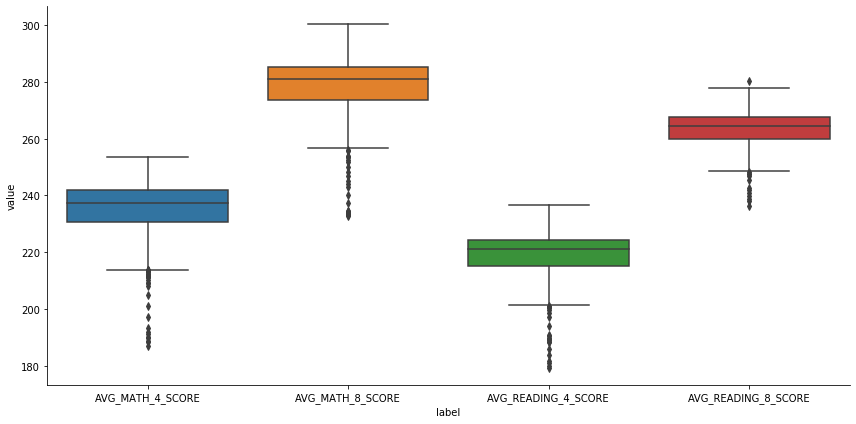

In [22]:
look_for_outliers(df_subset, [x for x in all_columns if 'SCORE' in x])

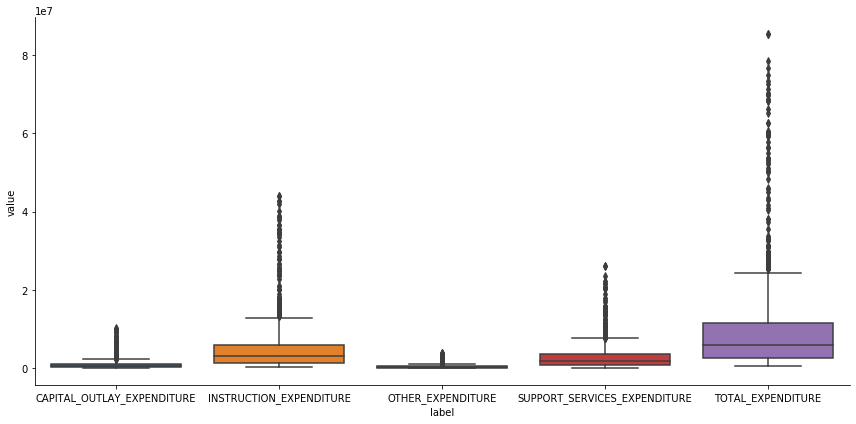

In [23]:
look_for_outliers(df_subset, [x for x in all_columns if 'EXPENDITURE' in x])

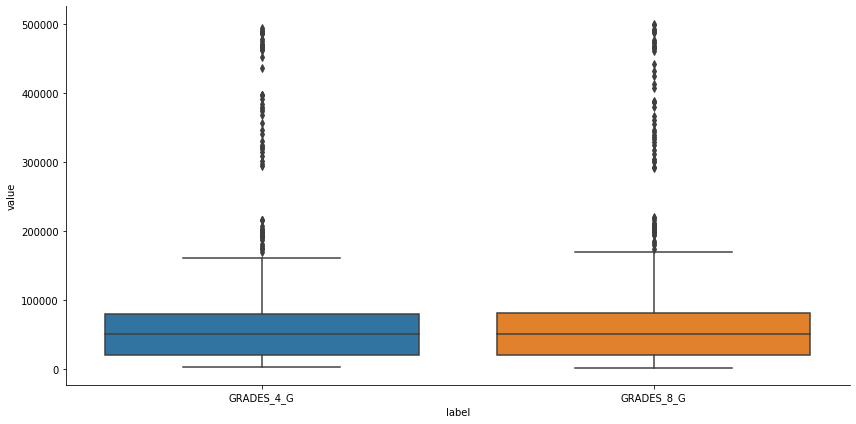

In [24]:
look_for_outliers(df_subset, ['GRADES_4_G', 'GRADES_8_G'])

**Observations:**

All values contain outliers. The scores are left skewed with small tails. The expenditure types and grades are right skewed with a long tail to large values.

Plan:
1. Log transform expenditure columns.
2. Recheck for outliers.
3. Leave grade columns alone as I will only interested in ratios between values to compute weighted averages.
4. Correct outliers in scores using Tukey.
5. If there are still outlies in log transformed expenditure columns, correct these using Tukey.

In [25]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1050
Data columns (total 11 columns):
AVG_MATH_4_SCORE                1051 non-null float64
AVG_MATH_8_SCORE                1051 non-null float64
AVG_READING_4_SCORE             1051 non-null float64
AVG_READING_8_SCORE             1051 non-null float64
TOTAL_EXPENDITURE               1051 non-null float64
INSTRUCTION_EXPENDITURE         1051 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1051 non-null float64
OTHER_EXPENDITURE               1051 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1051 non-null float64
GRADES_4_G                      1051 non-null float64
GRADES_8_G                      1051 non-null float64
dtypes: float64(11)
memory usage: 138.5 KB


In [26]:
expenditure_columns = [x for x in all_columns if 'EXPENDITURE' in x]
# print(expenditure_columns)
df_subset = log_transform(df_subset, expenditure_columns)

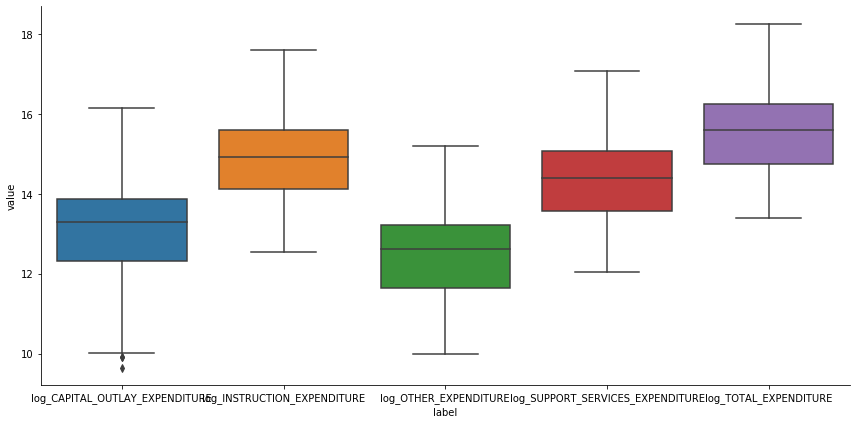

In [27]:
log_expenditure_columns = [f'log_{x}' for x in expenditure_columns]
look_for_outliers(df_subset, log_expenditure_columns)

Correct outliers in scores.

In [28]:
scores_columns = [x for x in all_columns if 'SCORE' in x]
df_subset = correct_outliers(df_subset, scores_columns)

In [29]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1050
Data columns (total 20 columns):
AVG_MATH_4_SCORE                    1051 non-null float64
AVG_MATH_8_SCORE                    1051 non-null float64
AVG_READING_4_SCORE                 1051 non-null float64
AVG_READING_8_SCORE                 1051 non-null float64
TOTAL_EXPENDITURE                   1051 non-null float64
INSTRUCTION_EXPENDITURE             1051 non-null float64
SUPPORT_SERVICES_EXPENDITURE        1051 non-null float64
OTHER_EXPENDITURE                   1051 non-null float64
CAPITAL_OUTLAY_EXPENDITURE          1051 non-null float64
GRADES_4_G                          1051 non-null float64
GRADES_8_G                          1051 non-null float64
log_TOTAL_EXPENDITURE               1051 non-null float64
log_INSTRUCTION_EXPENDITURE         1051 non-null float64
log_SUPPORT_SERVICES_EXPENDITURE    1051 non-null float64
log_OTHER_EXPENDITURE               1051 non-null float64
log_CAPITAL_OUTLAY_EXPE

In [30]:
corrected_scores_columns = [f'tukey_{x}' for x in scores_columns]

## Weighted average
1. Compute fractions of 4th and 8th graders and save to new columns
2. Compute weighted averages using fractions.
3. Check for outliers.
4. Correct outliers using Tukey.

In [31]:
columns = []
columns += corrected_scores_columns  # score columns
columns += log_expenditure_columns  # expenditure columns
columns += ['GRADES_4_G', 'GRADES_8_G']  # grade columns
df_subset = df_subset.loc[:, columns].copy()

In [32]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1050
Data columns (total 11 columns):
tukey_AVG_MATH_4_SCORE              1051 non-null float64
tukey_AVG_MATH_8_SCORE              1051 non-null float64
tukey_AVG_READING_4_SCORE           1051 non-null float64
tukey_AVG_READING_8_SCORE           1051 non-null float64
log_TOTAL_EXPENDITURE               1051 non-null float64
log_INSTRUCTION_EXPENDITURE         1051 non-null float64
log_SUPPORT_SERVICES_EXPENDITURE    1051 non-null float64
log_OTHER_EXPENDITURE               1051 non-null float64
log_CAPITAL_OUTLAY_EXPENDITURE      1051 non-null float64
GRADES_4_G                          1051 non-null float64
GRADES_8_G                          1051 non-null float64
dtypes: float64(11)
memory usage: 98.5 KB


In [33]:
def compute_average_weighted_scores(df):
    df['FRAC_GRADES_4'] = df['GRADES_4_G'] / (df['GRADES_4_G'] + df['GRADES_8_G'])
    df['FRAC_GRADES_8'] = df['GRADES_8_G'] / (df['GRADES_4_G'] + df['GRADES_8_G'])
    
    df['AVG_MATH_SCORES'] = (df['tukey_AVG_MATH_4_SCORE'] + df['tukey_AVG_MATH_8_SCORE']) / 2
    df['AVG_READING_SCORES'] = (df['tukey_AVG_READING_4_SCORE'] + df['tukey_AVG_READING_8_SCORE']) / 2
    
    df['WEIGHTED_AVG_MATH_SCORES'] = df['tukey_AVG_MATH_4_SCORE']*df['FRAC_GRADES_4'] + df['tukey_AVG_MATH_8_SCORE']*df['FRAC_GRADES_8']
    df['WEIGHTED_AVG_READING_SCORES'] = df['tukey_AVG_READING_4_SCORE']*df['FRAC_GRADES_4'] + df['tukey_AVG_READING_8_SCORE']*df['FRAC_GRADES_8']
    
    df['WEIGHTED_AVG_SCORES'] = (df['AVG_MATH_SCORES'] + df['AVG_READING_SCORES']) / 2
    
    return df

In [34]:
df_subset = compute_average_weighted_scores(df_subset)

### Look for outliers
Let's see if there are any outliers in the weighted averages column.

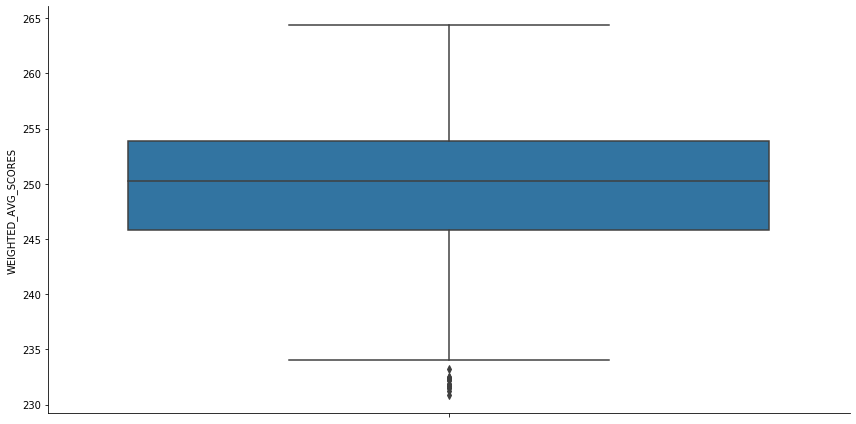

In [35]:
look_for_outliers(df_subset, ['WEIGHTED_AVG_SCORES'])

There are only a few outliers at the bottom. Let's leave them in and continue with the analysis.

## Correlations
Calculate correlation between weighted average score and expenditure types.

1. Define column subset
2. Standardize all values between 0 and 1, with a standard deviation of 1.
3. Use Pandas .corr() function to compute correlation coefficients.

In [36]:
columns = []
columns += log_expenditure_columns
columns.append('WEIGHTED_AVG_SCORES')

In [37]:
df_standard = pd.DataFrame(StandardScaler().fit_transform(df_subset.loc[:, columns]), columns=columns)

In [38]:
df_standard.describe()

,log_TOTAL_EXPENDITURE,log_INSTRUCTION_EXPENDITURE,log_SUPPORT_SERVICES_EXPENDITURE,log_OTHER_EXPENDITURE,log_CAPITAL_OUTLAY_EXPENDITURE,WEIGHTED_AVG_SCORES
count,1.051000e+03,1.051000e+03,1.051000e+03,1.051000e+03,1.051000e+03,1.051000e+03
mean,-1.216914e-16,3.752152e-16,-8.416991e-16,3.380317e-17,-1.656356e-16,-3.840041e-15
std,1.000476e+00,1.000476e+00,1.000476e+00,1.000476e+00,1.000476e+00,1.000476e+00
min,-2.063382e+00,-2.221267e+00,-2.220649e+00,-2.295888e+00,-2.919238e+00,-2.990196e+00
25%,-7.870343e-01,-7.529442e-01,-7.741245e-01,-7.729947e-01,-6.892989e-01,-5.850671e-01
50%,2.351136e-02,2.199550e-03,3.159070e-02,1.166915e-01,1.310709e-01,1.340986e-01
75%,6.406149e-01,6.454788e-01,6.718942e-01,6.617470e-01,6.017813e-01,7.126665e-01
max,2.533880e+00,2.526569e+00,2.583305e+00,2.485513e+00,2.492658e+00,2.410311e+00


In [39]:
df_standard.corr()['WEIGHTED_AVG_SCORES']

log_TOTAL_EXPENDITURE               0.204105
log_INSTRUCTION_EXPENDITURE         0.221682
log_SUPPORT_SERVICES_EXPENDITURE    0.187972
log_OTHER_EXPENDITURE               0.109798
log_CAPITAL_OUTLAY_EXPENDITURE      0.090068
WEIGHTED_AVG_SCORES                 1.000000
Name: WEIGHTED_AVG_SCORES, dtype: float64

**Observations:** 

Instruction expenditure has the highest correlation with weighted averaged scores, 0.22.

## PCA
Calculate PCA for the expenditure variables and compare with the overall weighted average.

1. Compute covariance matrix.
2. Compute eigenvalues and eigenvectors.
3. Plot eigenvalues.
4. Print eigenvectors.
5. Choose number of components to use when performing PCA.
6. Compute PCA.
7. Print variance explained ratios.

In [40]:
df_expenditures = df_standard.loc[:, log_expenditure_columns]

### Calculate covariance matrix.

In [41]:
X = StandardScaler().fit_transform(df_expenditures.loc[:, log_expenditure_columns])
Xt = X.T
Cx = np.cov(Xt)

print(f'Covariance matrix:\n {Cx}')

Covariance matrix:
 [[1.00095238 0.99826157 0.99615367 0.96172458 0.92062731]
 [0.99826157 1.00095238 0.99205996 0.95802474 0.90148602]
 [0.99615367 0.99205996 1.00095238 0.95558475 0.90483459]
 [0.96172458 0.95802474 0.95558475 1.00095238 0.8934869 ]
 [0.92062731 0.90148602 0.90483459 0.8934869  1.00095238]]


Compute eigen values and eigen vectors.

In [42]:
eigen_values, eigen_vectors = np.linalg.eig(Cx)

In [43]:
print(eigen_vectors)

[[-0.45505594 -0.15498715  0.25062941 -0.82738096 -0.1467267 ]
 [-0.45260655 -0.26931345  0.27758538  0.49561502 -0.63239994]
 [-0.45248057 -0.23988766  0.30980388  0.25284257  0.76013645]
 [-0.44491111 -0.19365841 -0.87391143  0.01157502  0.02636973]
 [-0.43056573  0.89911044  0.02077569  0.07578356 -0.00622892]]


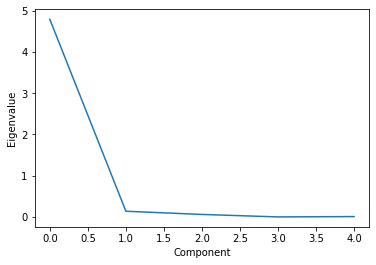

In [44]:
plt.plot(eigen_values)
plt.xlabel('Component')
plt.ylabel('Eigenvalue')
plt.show()

In [45]:
print(f'The eigen values are:\n {eigen_values}')

The eigen values are:
 [4.79572194e+00 1.38369106e-01 6.08378889e-02 7.79633459e-04
 9.05333595e-03]


### PCA - Scikit-Learn
Calculate principle components using Scikit-Learn.

In [46]:
sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X)

In [47]:
print(f'The variance explained ratio of the first component is {sklearn_pca.explained_variance_ratio_[0]:0.3f}.')

The variance explained ratio of the first component is 0.958.


In [48]:
df_compare = pd.DataFrame({'first_component': Y_sklearn[:, 0],
                           'weighted_avg_scores': df_standard['WEIGHTED_AVG_SCORES'].values})

In [49]:
df_compare.corr()

,first_component,weighted_avg_scores
first_component,1.000000,0.167163
weighted_avg_scores,0.167163,1.000000


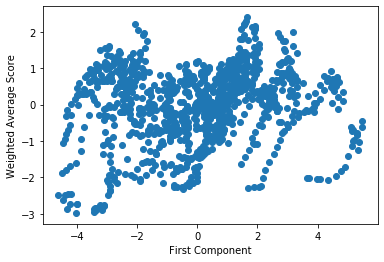

In [50]:
plt.scatter(Y_sklearn[:, 0], df_standard['WEIGHTED_AVG_SCORES'].values)
plt.xlabel('First Component')
plt.ylabel('Weighted Average Score')
plt.show()

### PCA - By Hand

In [51]:
P = eigen_vectors[:, 0]
Y = P.T.dot(Xt)

### Compare PCA Methods

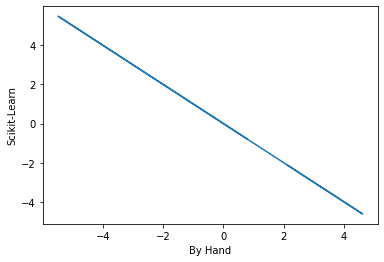

In [52]:
plt.plot(Y, Y_sklearn[:, 0])
plt.xlabel('By Hand')
plt.ylabel('Scikit-Learn')
plt.show()